## Step 0 : initializations

In [34]:
!pip install -q hazm
!pip install -q clean-text[gpl]
!pip install -q persian_wordcloud


In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import hazm
from cleantext import clean
from IPython.display import Image

#essential sklearn libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from persian_wordcloud.wordcloud import PersianWordCloud, add_stop_words


## Step 1 : Loading data And Preprocessings

first we load data From drive into df, and add it's column names.

In [36]:
df = pd.read_csv('/content/drive/MyDrive/NLP/HW2/Snappfood - Sentiment Analysis.csv', encoding='utf-8', sep='\t')
df = df[['comment', 'label', 'label_id']]

In [37]:
df

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0
...,...,...,...
69995,سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...,SAD,1.0
69996,سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...,SAD,1.0
69997,من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...,HAPPY,0.0
69998,همرو بعد ۲ساعت تاخیر اشتباه آوردن پولشم رفت رو...,SAD,1.0


Here we will check if there are any null values in the dataframe and drop them

In [38]:
df = df.dropna(axis='rows')
df.isna().sum()

comment     0
label       0
label_id    0
dtype: int64

As we can see from the below diagram the dataset is relatively balanced.

<Axes: xlabel='label', ylabel='count'>

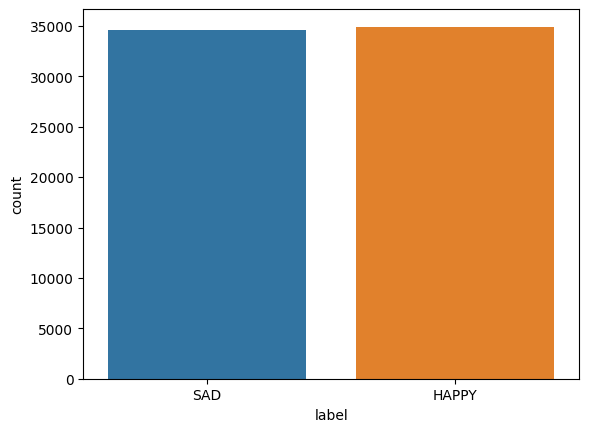

In [39]:
sns.countplot(x ='label', data = df)


Here we sample 20 percent of dataset as it's said in the HW.

In [40]:
sample_df = df.groupby('label_id').apply(lambda x: x.sample(frac=0.2,random_state=20))
sample_df

comment  label  \
label_id                                                                   
0.0      32286  مثل همیشه عالی جوجه کباب خوش طمع و برشته بود س...  HAPPY   
         22081                                بسیار خوشمزه و عالی  HAPPY   
         62728  ناپلئونی بد نیست اما باقلواشون زیادی عسلی و خش...  HAPPY   
         9901   سلام خیلی خوشمزه بود بخصوص طعم کنجد رو خیلی دو...  HAPPY   
         46283  گفته بودم سس مخصوص خودشون و بزارن چرا نزاشته ب...  HAPPY   
...                                                           ...    ...   
1.0      52332  طعم زردچوبه میداد خیلی زیاد. حالا یا بخاطر مون...    SAD   
         67032          واقعا افتضاح بود به تمام معنا خشک و سوخته    SAD   
         21346  نان سنگک دو رو کنجد زده بودن ولی کنجد رو به نا...    SAD   
         67506  کیفیت پیتزا خیلی پایین بود، طوری که قابل خوردن...    SAD   
         55106  مرغ ابپز و بدون رنگ و طعم بود. با عکسی که گذاش...    SAD   

                label_id  
label_id                  
0.0      32286       0.0  
         22081       0.0  
         62728       0.0  
         9901        0.0  
         46283       0.0  
...                  ...  
1.0      52332       1.0  
         67032       1.0  
         21346       1.0  
         67506       1.0  
         55106       1.0  

[13896 rows x 3 columns]

In [41]:
sample_df['label_id'].value_counts()

0.0    6983
1.0    6913
Name: label_id, dtype: int64

Here we are going to create a funtion called textPreprosseing to  fix unicode errors, make sentences lowercase, delete urls and delete hashtags. also we're going to delete extra charrecters and normalize using hazm library.

In [42]:
def clean_html(s):
    return re.sub(re.compile('<.*?>'), '', s)
    
def text_preprocessing(s):
  s = s.strip()
  s = clean(s,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=False,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="",
    replace_with_email="",
    replace_with_phone_number="",
    replace_with_number="",
    replace_with_digit="0",
    replace_with_currency_symbol="",
)
  
  s = clean_html(s)

  normalizer = hazm.Normalizer()
  s = normalizer.normalize(s)

  extra_characters = re.compile("["
    u"\U0001F600-\U0001F64F"  
    u"\U0001F300-\U0001F5FF"  
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u'\U00010000-\U0010ffff'
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    u"\u2069"
    u"\u2066"
    u"\u2068"
    u"\u2067"
    "]+", flags=re.UNICODE)

  s = extra_characters.sub(r'', s)
  s = re.sub("\s+", " ", s)         # trailing whitespace
  s = re.sub(r'(@.*?)[\s]', ' ', s) # @ mentions
  s = re.sub("#", "", s)            # hashtags

  return s


Here we'll call the preprosseing function and put cleaned comments in 'cleaned_comment' column

In [43]:
df_cleaned = sample_df
df_cleaned['cleaned_comment'] = sample_df['comment'].apply(text_preprocessing)
df_cleaned

comment  label  \
label_id                                                                   
0.0      32286  مثل همیشه عالی جوجه کباب خوش طمع و برشته بود س...  HAPPY   
         22081                                بسیار خوشمزه و عالی  HAPPY   
         62728  ناپلئونی بد نیست اما باقلواشون زیادی عسلی و خش...  HAPPY   
         9901   سلام خیلی خوشمزه بود بخصوص طعم کنجد رو خیلی دو...  HAPPY   
         46283  گفته بودم سس مخصوص خودشون و بزارن چرا نزاشته ب...  HAPPY   
...                                                           ...    ...   
1.0      52332  طعم زردچوبه میداد خیلی زیاد. حالا یا بخاطر مون...    SAD   
         67032          واقعا افتضاح بود به تمام معنا خشک و سوخته    SAD   
         21346  نان سنگک دو رو کنجد زده بودن ولی کنجد رو به نا...    SAD   
         67506  کیفیت پیتزا خیلی پایین بود، طوری که قابل خوردن...    SAD   
         55106  مرغ ابپز و بدون رنگ و طعم بود. با عکسی که گذاش...    SAD   

                label_id                                    cleaned_comment  
label_id                                                                     
0.0      32286       0.0  مثل همیشه عالی جوجه کباب خوش طمع و برشته بود س...  
         22081       0.0                                بسیار خوشمزه و عالی  
         62728       0.0  ناپلئونی بد نیست اما باقلواشون زیادی عسلی و خش...  
         9901        0.0  سلام خیلی خوشمزه بود بخصوص طعم کنجد رو خیلی دو...  
         46283       0.0  گفته بودم سس مخصوص خودشون و بزارن چرا نزاشته ب...  
...                  ...                                                ...  
1.0      52332       1.0  طعم زردچوبه میداد خیلی زیاد. حالا یا بخاطر مون...  
         67032       1.0          واقعا افتضاح بود به تمام معنا خشک و سوخته  
         21346       1.0  نان سنگک دو رو کنجد زده بودن ولی کنجد رو به نا...  
         67506       1.0  کیفیت پیتزا خیلی پایین بود، طوری که قابل خوردن...  
         55106       1.0  مرغ ابپز و بدون رنگ و طعم بود. با عکسی که گذاش...  

[13896 rows x 4 columns]

In [44]:
df_cleaned = df_cleaned.droplevel('label_id')
df_cleaned = df_cleaned.reset_index().drop(['index'], axis=1)
df_cleaned

,comment,label,label_id,cleaned_comment
0,مثل همیشه عالی جوجه کباب خوش طمع و برشته بود س...,HAPPY,0.0,مثل همیشه عالی جوجه کباب خوش طمع و برشته بود س...
1,بسیار خوشمزه و عالی,HAPPY,0.0,بسیار خوشمزه و عالی
2,ناپلئونی بد نیست اما باقلواشون زیادی عسلی و خش...,HAPPY,0.0,ناپلئونی بد نیست اما باقلواشون زیادی عسلی و خش...
3,سلام خیلی خوشمزه بود بخصوص طعم کنجد رو خیلی دو...,HAPPY,0.0,سلام خیلی خوشمزه بود بخصوص طعم کنجد رو خیلی دو...
4,گفته بودم سس مخصوص خودشون و بزارن چرا نزاشته ب...,HAPPY,0.0,گفته بودم سس مخصوص خودشون و بزارن چرا نزاشته ب...
...,...,...,...,...
13891,طعم زردچوبه میداد خیلی زیاد. حالا یا بخاطر مون...,SAD,1.0,طعم زردچوبه میداد خیلی زیاد. حالا یا بخاطر مون...
13892,واقعا افتضاح بود به تمام معنا خشک و سوخته,SAD,1.0,واقعا افتضاح بود به تمام معنا خشک و سوخته
13893,نان سنگک دو رو کنجد زده بودن ولی کنجد رو به نا...,SAD,1.0,نان سنگک دو رو کنجد زده بودن ولی کنجد رو به نا...
13894,کیفیت پیتزا خیلی پایین بود، طوری که قابل خوردن...,SAD,1.0,کیفیت پیتزا خیلی پایین بود، طوری که قابل خوردن...


## step 2 : Tf-Idf implementation

Here we create train and test data and as it is said in hw it wiill be 90 percent train data and 10 percenttest data.

In [55]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['cleaned_comment'], df_cleaned['label_id'], test_size=0.1, stratify=df_cleaned['label_id'], random_state=42,shuffle=True)

In [56]:
word_dictionary = list()
words = X_train.str.split(' ')
for row in X_train:
  row = row.split()
  for word in row:
    if word not in word_dictionary:
      word_dictionary.append(word)

print("this dataset has a vocabulary with size of : " ,len(word_dictionary))

this dataset has a vocabulary with size of :  16995


Here we'll create the TfIdf classifier that calculates tf and idf and then using cal_tf_idf calculates tf-idf all all of the dataset.

In [57]:
class TfIdfClassifier:
    def set_vocab(self, vocab):
        self.vocab = vocab
        self.model = MultinomialNB()
        self.idf = {}

    def fit(self, train_input, train_output):
        self.calculate_idf(train_input)
        self.model.fit(self.data_vector(train_input), train_output)

    def predict(self, test_input):
        return self.model.predict(self.data_vector(test_input))

    def data_vector(self, data):
        result = []
        for sentence in data:
            result.append(self.calculate_tf_idf(sentence))
        return np.array(result)

    def calculate_tf_idf(self, sentence):
        vector = []
        for word in self.vocab:
            if word in sentence:
                vector.append(math.log(self.idf[word] + 1))
            else:
                vector.append(0)
        return vector

    def calculate_idf(self, data):
        word_in_doc_list = {}
        for sentence in data:
            sentence = sentence.split()
            for word in sentence:
                if word not in word_in_doc_list:
                    word_in_doc_list[word] = []
                if sentence not in word_in_doc_list[word]:
                    word_in_doc_list[word].append(sentence)
        for word in word_in_doc_list:
            total_doc_with_word = len(word_in_doc_list[word])
            self.idf[word] = len(data) / total_doc_with_word


In [59]:
import math
tfidf_clsfr = TfIdfClassifier()
tfidf_clsfr.set_vocab(word_dictionary)
tfidf_clsfr.fit(X_train, y_train)

In [60]:
pred = tfidf_clsfr.predict(X_test)


In [61]:
accuracy = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
f1 = f1_score(pred, y_test, average="weighted")


In [ ]:
print("tf-idf Accuracy:", accuracy)
print("tf-idf Precision:", precision)
print("tf-idf Recall:", recall)
print("tf-idf F1 Score:", f1)

tf-idf Accuracy: 0.7942446043165468
tf-idf Precision: 0.7905308464849354
tf-idf Recall: 0.7973950795947902
tf-idf F1 Score: 0.7942433263962219


## PPMI

In [45]:
df_cleaned.loc[1501,['label_id','cleaned_comment']].tolist()[1]

'خیلی خوب بود فقط کمی شور بود'

In [46]:
from  hazm import *
def tokenizer(term):
  cleaned = re.sub('(([^ا-ی\.!\?1-9])*[A-Za-z])+','',term)
  cleaned = re.sub('\n','',cleaned)
  normalizer = Normalizer()
  cleaned = normalizer.normalize(cleaned)
  return word_tokenize(cleaned)
  

In [47]:
vocabulary = set()
word_count = {}
tokenized_labeled_data = list()
all_words_count = 0

for i in range(len(df_cleaned.index)):
  tokens = tokenizer(df_cleaned.loc[i,['label_id','cleaned_comment']].tolist()[1])
  tokenized_labeled_data.append([tokens, df_cleaned.loc[i,['label_id','cleaned_comment']].tolist()[0]])
  all_words_count = all_words_count + len(tokens)
  vocabulary = vocabulary.union(set(tokens))
  for t in tokens:
    if t in word_count.keys():
      word_count[t] = word_count[t] + 1
    else:
      word_count[t] = 1

In [48]:
df_co = pd.DataFrame(data=np.zeros((len(vocabulary), len(vocabulary)), 
                  dtype=np.int16),
                  index=list(vocabulary),
                  columns=list(vocabulary))
for data in tokenized_labeled_data:
  for i in range(len(data[0])):
      next_token = data[0][i+1 : i+3] # take window size = 2
      for t in next_token:
        df_co.at[data[0][i], t] += 1
        df_co.at[t, data[0][i]] += 1

\begin{align*}
P(i,j) = \frac{C(i,j)}{\sum_{k,l} C(k,l)} = \frac{C_{ij}}{Z} \\\\
P(i) = \frac{\sum_{k} C(i,k)}{\sum_{k,l} C(k,l)} = \frac{Z_i}{Z} \\\\
\end{align*}

Then compute PMI:

\begin{align*}
\text{PMI}(i,j) = \log \frac{P(i,j)}{P(i)P(j)} = \log \frac{C_{ij} \cdot Z}{Z_i \cdot Z_j} \\\\
\end{align*}

Finally, truncate to ignore negatively-correlated pairs:

\begin{align*}
\text{PPMI}(i,j) = \max(0, \text{PMI}(i,j))
\end{align*}

In [49]:
expct = np.outer((df_co.sum(axis=1)), (df_co.sum(axis=0))) / (df_co.sum(axis=0).sum())
PMI = df_co / expct

with np.errstate(divide='ignore'):
    PMI = np.log(PMI)
PMI[np.isinf(PMI)] = 0.0

PMI[PMI < 0] = 0.0
PPMI = PMI

In [50]:
new_list = [d for d in tokenized_labeled_data if d[0]]  # remove items where d[0] is empty
PPMI_data = []
for d in new_list:
  vorctors_list = []
  for w in d[0]:
    vorctors_list.append(PPMI[w].to_numpy()) 
  PPMI_data.append(np.mean(vorctors_list, 0))



In [ ]:
X = PPMI_data
Y = np.array(new_list)[:,1].astype('int')

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=354)


In [53]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [54]:
y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")
print("ppmi Accuracy:", accuray)
print("ppmi Precision:", precision)
print("ppmi Recall:", recall)
print("ppmi F1 Score:", f1)

ppmi Accuracy: 0.7352092352092352
ppmi Precision: 0.7193211488250653
ppmi Recall: 0.7193211488250653
ppmi F1 Score: 0.73593259649943
